In [1]:
from urllib.request import urlopen
import warnings

import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from highlight_text import ax_text

from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen

In [10]:
parser = Sbopen()
events, related, freeze, tactics = parser.event(18245)
lineup = parser.lineup(18245)

In [12]:
time_off = events.loc[(events.type_name == 'Substitution'), ['player_id', 'minute']]
time_off.rename({'minute': 'off'}, axis='columns', inplace=True)

time_on = events.loc[(events.type_name == 'Substitution'), ['substitution_replacement_id', 'minute']]
time_on.rename({'substitution_replacement_id': 'player_id', 'minute': 'on'}, axis='columns', inplace=True)

players_on = time_on.player_id

lineup = lineup.merge(time_on, on='player_id', how='left')
lineup = lineup.merge(time_off, on='player_id', how='left')

lineup

,player_id,player_name,player_nickname,jersey_number,match_id,team_id,team_name,country_id,country_name,on,off
0,3471,Dejan Lovren,Dejan Lovren,6,18245,24,Liverpool,56,Croatia,NaN,NaN
1,3473,James Philip Milner,James Milner,7,18245,24,Liverpool,68,England,NaN,82.0
2,3493,Emre Can,Emre Can,23,18245,24,Liverpool,85,Germany,82.0,NaN
3,3515,Alberto Moreno Pérez,Alberto Moreno,18,18245,24,Liverpool,214,Spain,NaN,NaN
4,3531,Mohamed Salah,Mohamed Salah,11,18245,24,Liverpool,66,Egypt,NaN,29.0
5,3532,Jordan Brian Henderson,Jordan Henderson,14,18245,24,Liverpool,68,England,NaN,NaN
6,3535,Roberto Firmino Barbosa de Oliveira,Roberto Firmino,9,18245,24,Liverpool,31,Brazil,NaN,NaN
7,3539,Simon Mignolet,Simon Mignolet,22,18245,24,Liverpool,22,Belgium,NaN,NaN
8,3567,Georginio Wijnaldum,Georginio Wijnaldum,5,18245,24,Liverpool,160,Netherlands,NaN,NaN
9,3614,Dominic Solanke,Dominic Solanke,29,18245,24,Liverpool,68,England,NaN,NaN


In [16]:
starting_ids = events[events.type_name == 'Starting XI'].id 
starting_xi = tactics[tactics.id.isin(starting_ids)]
starting_players = starting_xi.player_id

mask_played = ((lineup.on.notnull()) | (lineup.off.notnull()) | (lineup.player_id.isin(starting_players)))
lineup = lineup[mask_played].copy()

player_positions = (events[['player_id', 'position_id']].dropna(how='any', axis='rows').drop_duplicates('player_id', keep='first'))

lineup = lineup.merge(player_positions, how='left', on='player_id')

formation_dict = {
    1: 'GK',
    2: 'RB',
    3: 'RCB',
    4: 'CB',
    5: 'LCB',
    6: 'LB',
    7: 'RWB',
    8: 'LWB',
    9: 'RDM',
    10: 'CDM',
    11: 'LDM',
    12: 'RM',
    13: 'RCM',
    14: 'CM',
    15: 'LCM',
    16: 'LM',
    17: 'RW',
    18: 'RAM',
    19: 'CAM',
    20: 'LAM',
    21: 'LW',
    22: 'RCF',
    23: 'ST',
    24: 'LCF',
    25: 'SS'
}
lineup['position_abbreviation'] = lineup.position_id.map(formation_dict)

lineup['start'] = lineup.player_id.isin(starting_players)
lineup.sort_values(['team_name', 'start', 'on', 'position_id'],ascending=[True, False, True, True], inplace=True)

lineup

,player_id,player_name,player_nickname,jersey_number,match_id,team_id,team_name,country_id,country_name,on,off,position_id,position_abbreviation,start
8,3630,Loris Karius,Loris Karius,1,18245,24,Liverpool,85,Germany,NaN,NaN,1.0,GK,True
10,3664,Trent Alexander-Arnold,Trent Alexander-Arnold,66,18245,24,Liverpool,68,England,NaN,NaN,2.0,RB,True
0,3471,Dejan Lovren,Dejan Lovren,6,18245,24,Liverpool,56,Croatia,NaN,NaN,3.0,RCB,True
11,3669,Virgil van Dijk,Virgil van Dijk,4,18245,24,Liverpool,160,Netherlands,NaN,NaN,5.0,LCB,True
9,3655,Andrew Robertson,Andrew Robertson,26,18245,24,Liverpool,201,Scotland,NaN,NaN,6.0,LB,True
4,3532,Jordan Brian Henderson,Jordan Henderson,14,18245,24,Liverpool,68,England,NaN,NaN,10.0,CDM,True
6,3567,Georginio Wijnaldum,Georginio Wijnaldum,5,18245,24,Liverpool,160,Netherlands,NaN,NaN,13.0,RCM,True
1,3473,James Philip Milner,James Milner,7,18245,24,Liverpool,68,England,NaN,82.0,15.0,LCM,True
3,3531,Mohamed Salah,Mohamed Salah,11,18245,24,Liverpool,66,Egypt,NaN,29.0,17.0,RW,True
7,3629,Sadio Mané,Sadio Mané,19,18245,24,Liverpool,202,Senegal,NaN,NaN,21.0,LW,True


In [23]:
team1, team2 = lineup.team_name.unique()

team = team1
lineup_team = lineup[lineup.team_name == team].copy()

set_pieces = ['Throw-in', 'Free Kick', 'Corner', 'Kick off', 'Goal Kick']

pass_receipts = events[(events.team_name == team) & (events.type_name == 'Ball Receipt')].copy()

passes_excl_throw = events[(events.team_name == team) & (events.type_name == 'Pass') & (events.sub_type_name != 'Throw-in')].copy()

num_players = len(lineup_team)
num_sub = num_players - 11

In [24]:
# add padding to the top so we can plot the titles, and raise the pitch lines
pitch = Pitch(pad_top=10, line_zorder=2)

# arrow properties for the sub on/off
green_arrow = dict(arrowstyle='simple, head_width=0.7',
                   connectionstyle="arc3,rad=-0.8", fc="green", ec="green")
red_arrow = dict(arrowstyle='simple, head_width=0.7',
                 connectionstyle="arc3,rad=-0.8", fc="red", ec="red")

# a fontmanager object for using a google font
fm_scada = FontManager('https://raw.githubusercontent.com/googlefonts/scada/main/fonts/ttf/'
                       'Scada-Regular.ttf')

# Load the Club/ Statsbomb logos
# these are the property of the respective clubs/ StatsBomb.
LIV_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/thumb/0/0c/Liverpool_FC.svg/270px-Liverpool_FC.svg.png')
MADRID_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/thumb/5/56/Real_Madrid_CF.svg/240px-Real_Madrid_CF.svg.png')
SB_LOGO_URL = ('https://raw.githubusercontent.com/statsbomb/open-data/'
               'master/img/SB%20-%20Icon%20Lockup%20-%20Colour%20positive.png')
liv_logo = Image.open(urlopen(LIV_LOGO_URL))
madrid_logo = Image.open(urlopen(MADRID_LOGO_URL))
sb_logo = Image.open(urlopen(SB_LOGO_URL))

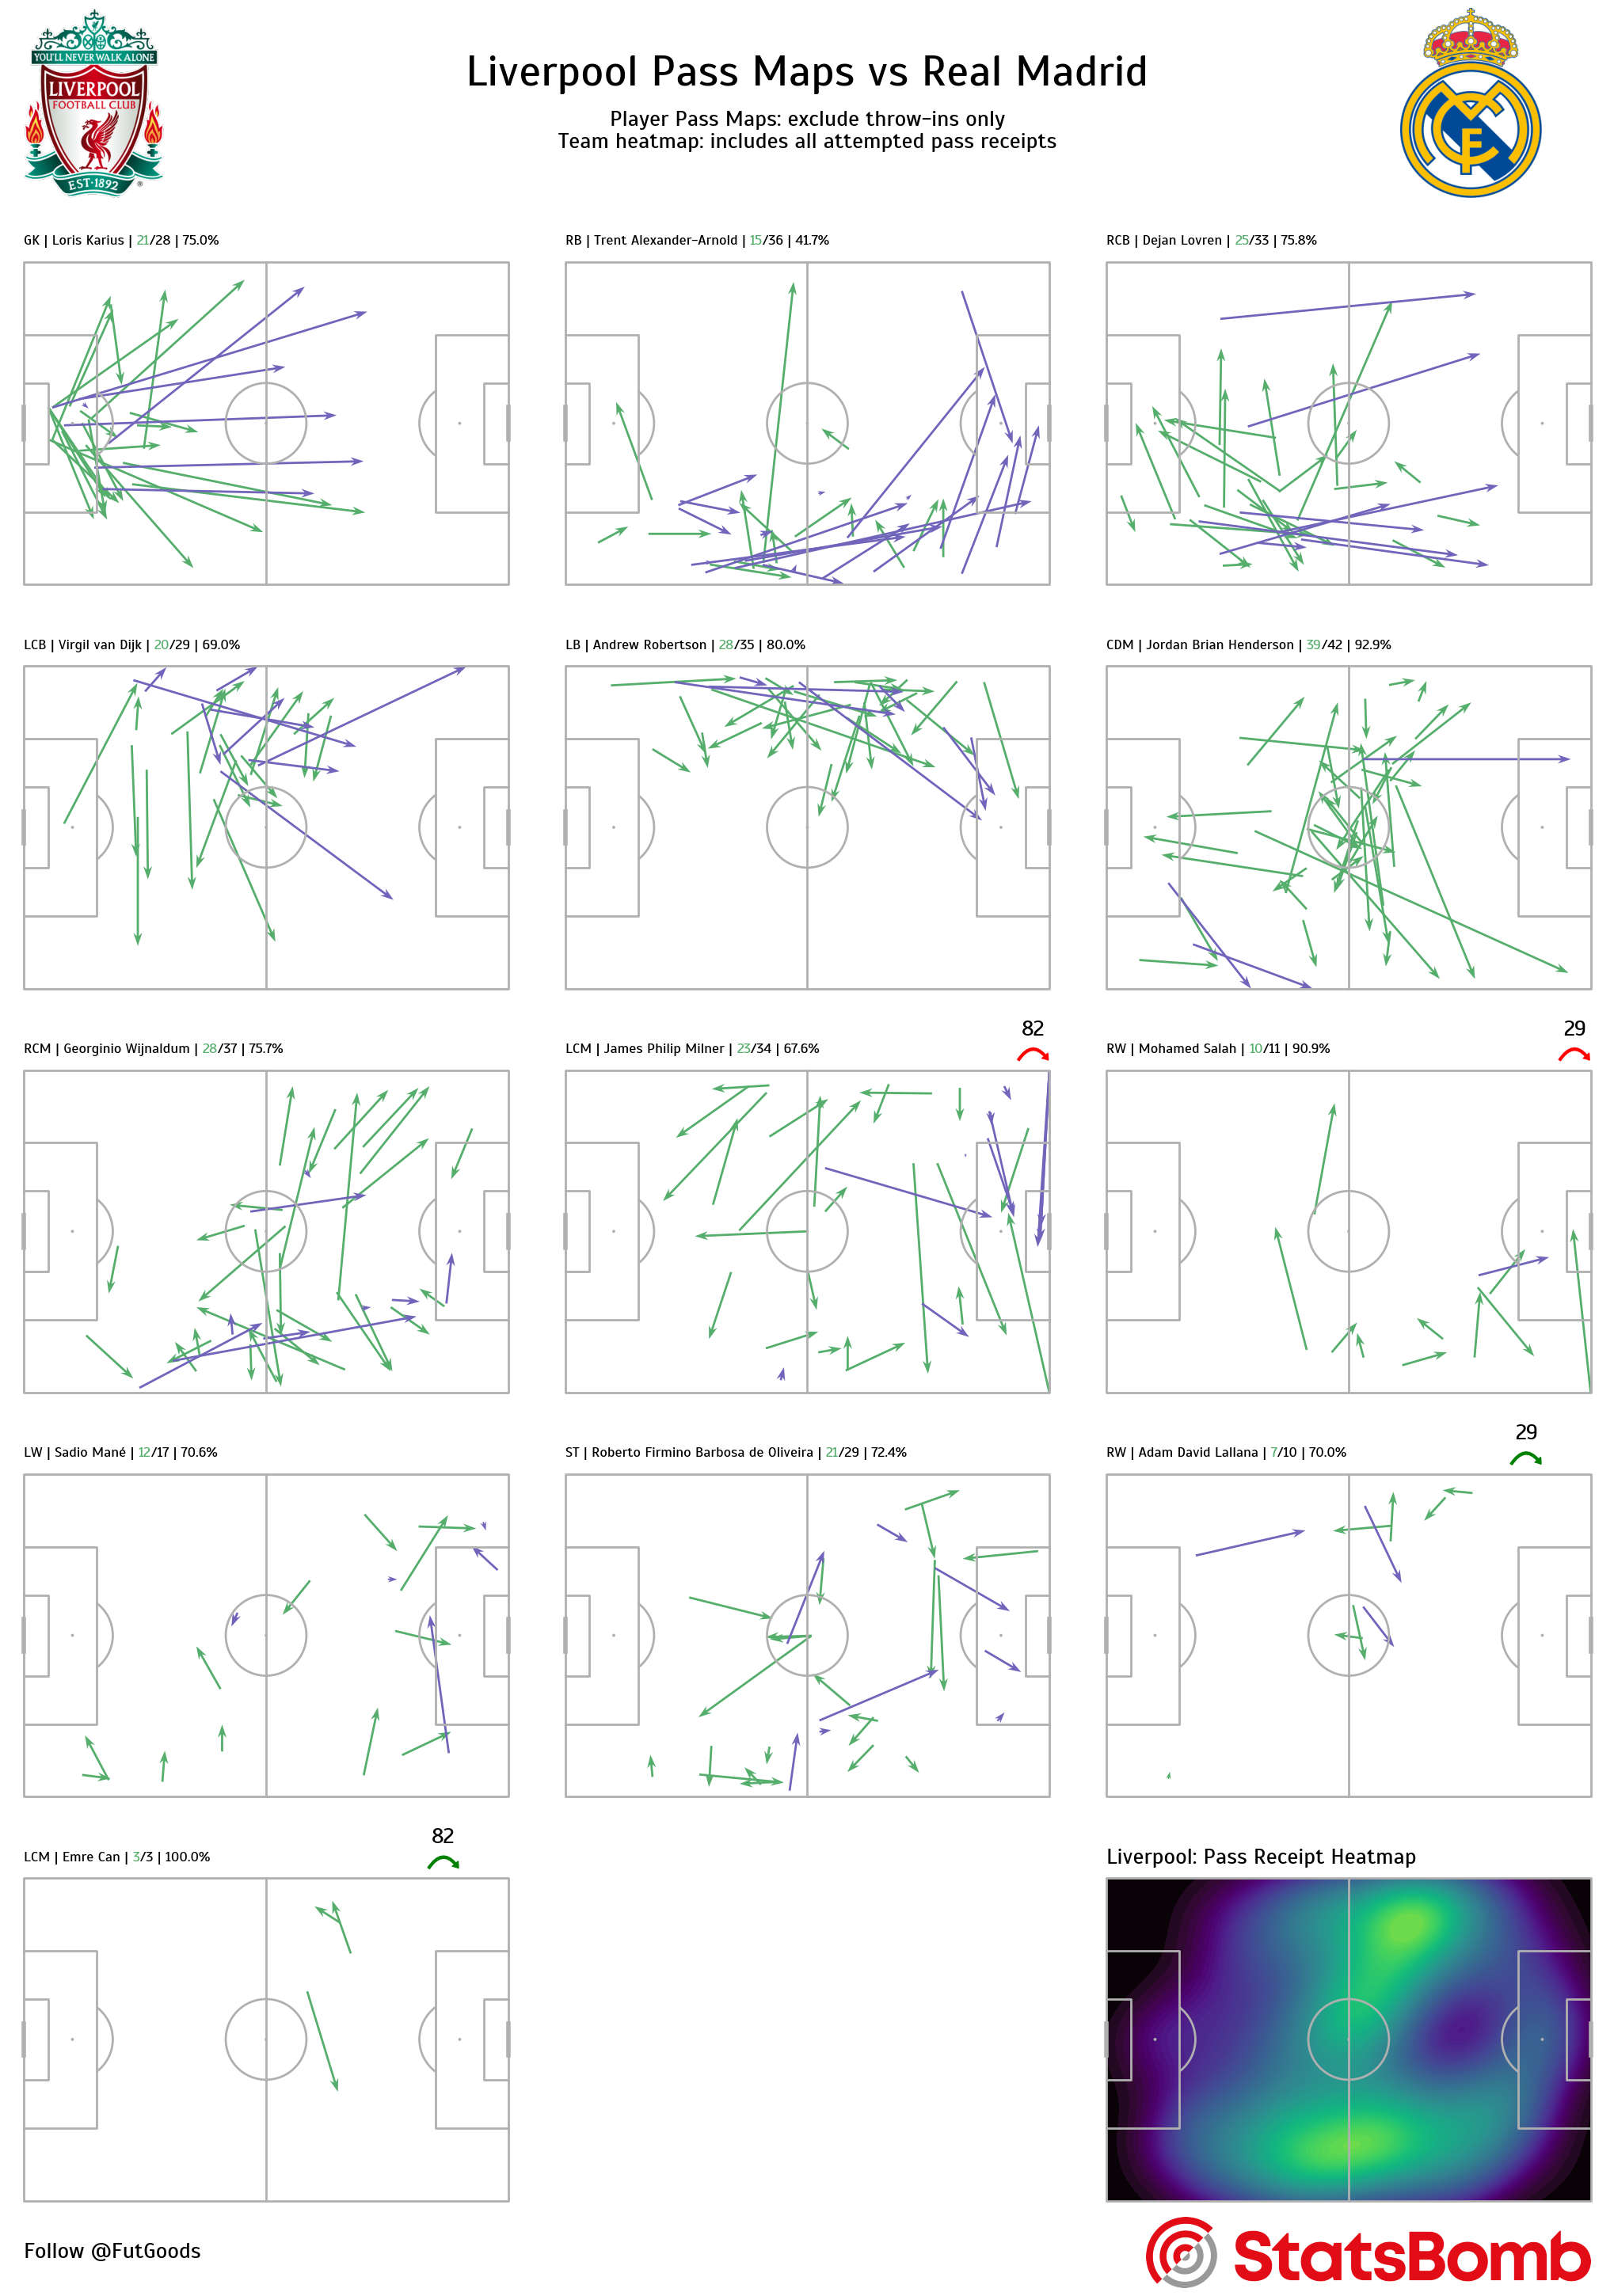

In [31]:

warnings.simplefilter("ignore", UserWarning)

fig, axs = pitch.grid(nrows=5, ncols=3, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      axis=False,
                      title_height=0.08, grid_height=0.84)

for idx, ax in enumerate(axs['pitch'].flat):
    if idx < num_players:
        lineup_player = lineup_team.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes_excl_throw[passes_excl_throw.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#56ae6c', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)

        total_pass = len(complete_pass) + len(incomplete_pass)
        annotation_string = (f'{lineup_player.position_abbreviation} | '
                             f'{lineup_player.player_name} | '
                             f'<{len(complete_pass)}>/{total_pass} | '
                             f'{round(100 * len(complete_pass)/total_pass, 1)}%')
        ax_text(0, -5, annotation_string, ha='left', va='center', fontsize=13,
                fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

        # add information for subsitutions on/off and arrows
        if not np.isnan(lineup_team.iloc[idx].off):
            ax.text(116, -10, str(lineup_team.iloc[idx].off.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (120, -2), (112, -2), arrowprops=red_arrow)
        if not np.isnan(lineup_team.iloc[idx].on):
            ax.text(104, -10, str(lineup_team.iloc[idx].on.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (108, -2), (100, -2), arrowprops=green_arrow)

# plot on the last Pass Map
# (note ax=ax as we have cycled through to the last axes in the loop)
pitch.kdeplot(x=pass_receipts.x, y=pass_receipts.y, ax=ax,
              cmap=cmr.lavender,
              levels=100,
              thresh=0, fill=True)
ax.text(0, -5, f'{team}: Pass Receipt Heatmap', ha='left', va='center',
        fontsize=20, fontproperties=fm_scada.prop)

# remove unused axes (if any)
for ax in axs['pitch'].flat[11 + num_sub:-1]:
    ax.remove()

# endnote text
axs['endnote'].text(0, 0.5, 'Follow @FutGoods',
                    fontsize=20, fontproperties=fm_scada.prop, va='center', ha='left')

ax_sb_logo = add_image(sb_logo, fig, left=0.701126,
                       # set the bottom and height to align with the endnote
                       bottom=axs['endnote'].get_position().y0,
                       height=axs['endnote'].get_position().height)

# title text
axs['title'].text(0.5, 0.65, f'{team1} Pass Maps vs {team2}', fontsize=40,
                  fontproperties=fm_scada.prop, va='center', ha='center')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only\n'
            'Team heatmap: includes all attempted pass receipts')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                  fontproperties=fm_scada.prop, va='center', ha='center')
# plot logos (same height as the title_ax)
# set the barca logo to align with the left/bottom of the title axes
ax_liv_logo = add_image(liv_logo, fig,
                          left=axs['title'].get_position().x0,
                          bottom=axs['title'].get_position().y0,
                          height=axs['title'].get_position().height)

ax_madrid_logo = add_image(madrid_logo, fig, left=0.8521,
                              bottom=axs['title'].get_position().y0,
                              height=axs['title'].get_position().height)
# setting this example to the gallery thumbnail
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_grid_005'

plt.show()  # If you are using a Jupyter notebook you do not need this line